## Restore the variables from the last session

In [2]:
store -r

Unable to restore variable 'credit_df', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


## What is Autoencoder?
Autoencoder is an unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.
Autoencoder, by design, reduces data dimensions by learning how to ignore the noise in the data.
Here is an example of the input/output image from the MNIST dataset to an autoencoder.


<img src="./images/autoencoder.png">


### Autoencoders consists of 4 main parts:
1- **Encoder**: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2- **Bottleneck**: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data.

3- **Decoder**: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

4- **Reconstruction Loss**: This is the method that measures measure how well the decoder is performing and how close the output is to the original input.

## Why Autoencoder works for Anomaly Detection?
Autoencoders are great in learning what is normal. I can identify the normal region ina distribution then anything that is considered an outlier will return a high reconstruction error.

Let's start by installing some pre-requisite libraries. H2O is an open-source library that can be used to do a number of machine learning tasks. It has a function for the autoencoders. Let's have a look

In [3]:
!pip install h2o

You are using pip version 10.0.1, however version 19.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Importing necessary libraries

In [1]:
import h2o
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator

## Starting and initializing H2O server.

In [2]:
h2o.init(max_mem_size = 2) # initializing h2o server
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.152-b16, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ADMINI~1\AppData\Local\Temp\tmpojdlf4gi
  JVM stdout: C:\Users\ADMINI~1\AppData\Local\Temp\tmpojdlf4gi\h2o_Administrator_started_from_python.out
  JVM stderr: C:\Users\ADMINI~1\AppData\Local\Temp\tmpojdlf4gi\h2o_Administrator_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Asia/Shanghai
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.1
H2O_cluster_version_age:    11 days
H2O_cluster_name:           H2O_from_python_Administrator_wr9n1w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.778 Gb
H2O_cluster_total_cores:    16
H2O_cluster_allowed_cores:  16
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.5 final
--------------------------  ------------------------------------

## Loading the dataset into a H2O dataframe and splitting the DS.

In [4]:
creditData_df = h2o.import_file(r"data/creditcard.csv") 
features= creditData_df.drop(['Time'], axis=1)
train, test = features.split_frame([0.8])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Preprocess the dataset

In [5]:
# converting to pandas dataframe
train_df = train.as_data_frame()
test_df = test.as_data_frame()

train_df = train_df[train_df['Class'] == 0]
fraud_df = train_df[train_df['Class'] == 1]

# drop the Class variable
train_df = train_df.drop(['Class'], axis=1)
Y_test_df = test_df['Class'] # true labels of the testing set
test_df = test_df.drop(['Class'], axis=1)

# converting to h2o frame
train_h2o = h2o.H2OFrame(train_df) 
test_h2o = h2o.H2OFrame(test_df)
train_cols = train_h2o.columns

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Create a local estimator and start the training process

In [14]:
anomaly_model = H2OAutoEncoderEstimator(activation = "Tanh",
                               hidden = [14,7,7,14],
                               epochs = 100,
                               standardize = True,
                                stopping_metric = 'MSE', 
                                loss = 'automatic',
                                train_samples_per_iteration = 32,
                                shuffle_training_data = True,     
                               autoencoder = True,
                               l1 = 10e-5)


In [11]:
train_cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [15]:
anomaly_model.train(x=train_cols, training_frame = train_h2o)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Model Details
H2OAutoEncoderEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1650821774448_1


Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 1,128 weights/biases, 21.4 KB, 3,178,691 training samples, mini-batch size 1


layer  units   type dropout      l1   l2 mean_rate  rate_rms momentum  \
0        1     29  Input     0.0                                             
1        2     14   Tanh     0.0  0.0001  0.0  0.783183  0.270934      0.0   
2        3      7   Tanh     0.0  0.0001  0.0  0.679162  0.396646      0.0   
3        4      7   Tanh     0.0  0.0001  0.0  0.352497  0.384759      0.0   
4        5     14   Tanh     0.0  0.0001  0.0  0.655466  0.421451      0.0   
5        6     29   Tanh          0.0001  0.0  0.588932  0.444597      0.0   

  mean_weight weight_rms mean_bias  bias_rms  
0                                             
1   -0.000016   0.203265  0.001248  0.011835  
2    -0.04641   0.272627  0.001016   0.00271  
3     0.03719   0.335823  0.000583  0.000439  
4   -0.000221    0.20617  0.000508  0.001464  
5    0.006885   0.089134  0.000079  0.006345



ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.0008445260032361693
RMSE: 0.02906072957164306

Scoring History: 


timestamp           duration   training_speed     epochs  \
0     2022-04-25 01:46:27          0.421 sec  0.00000 obs/sec   0.000000   
1     2022-04-25 01:46:32          5.371 sec    32792 obs/sec   0.711641   
2     2022-04-25 01:46:37         10.366 sec    33825 obs/sec   1.475555   
3     2022-04-25 01:46:42         15.366 sec    34203 obs/sec   2.242720   
4     2022-04-25 01:46:47         20.368 sec    33985 obs/sec   2.974467   
5     2022-04-25 01:46:52         25.369 sec    33241 obs/sec   3.638927   
6     2022-04-25 01:46:57         30.370 sec    32746 obs/sec   4.303404   
7     2022-04-25 01:47:02         35.372 sec    32356 obs/sec   4.962252   
8     2022-04-25 01:47:07         40.373 sec    32050 obs/sec   5.618632   
9     2022-04-25 01:47:12         45.374 sec    31812 obs/sec   6.274932   
10    2022-04-25 01:47:17         50.375 sec    31615 obs/sec   6.929756   
11    2022-04-25 01:47:22         55.378 sec    31437 obs/sec   7.580563   
12    2022-04-25 01:47:27   1 min  0.376 sec    31276 obs/sec   8.227962   
13    2022-04-25 01:47:32   1 min  5.376 sec    31132 obs/sec   8.873391   
14    2022-04-25 01:47:37   1 min 10.377 sec    31011 obs/sec   9.519555   
15    2022-04-25 01:47:42   1 min 15.378 sec    30891 obs/sec  10.160933   
16    2022-04-25 01:47:47   1 min 20.379 sec    30781 obs/sec  10.800273   
17    2022-04-25 01:47:52   1 min 25.380 sec    30684 obs/sec  11.439899   
18    2022-04-25 01:47:57   1 min 30.381 sec    30589 obs/sec  12.075912   
19    2022-04-25 01:48:02   1 min 35.382 sec    30494 obs/sec  12.708046   

    iterations    samples  training_rmse  training_mse  
0            0        0.0       0.061973      0.003841  
1         5088   161963.0       0.031556      0.000996  
2        10542   335823.0       0.029340      0.000861  
3        16018   510423.0       0.030534      0.000932  
4        21239   676962.0       0.029220      0.000854  
5        25979   828187.0       0.029350      0.000861  
6        30711   979416.0       0.029871      0.000892  
7        35422  1129364.0       0.029634      0.000878  
8        40121  1278750.0       0.029776      0.000887  
9        44808  1428118.0       0.029150      0.000850  
10       49466  1577150.0       0.029470      0.000868  
11       54106  1725268.0       0.030076      0.000905  
12       58726  1872610.0       0.029280      0.000857  
13       63323  2019504.0       0.029384      0.000863  
14       67934  2166565.0       0.029306      0.000859  
15       72516  2312537.0       0.029381      0.000863  
16       77073  2458045.0       0.029539      0.000873  
17       81625  2603618.0       0.029780      0.000887  
18       86159  2748369.0       0.029667      0.000880  
19       90680  2892237.0       0.029061      0.000845


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0       V15             1.000000           1.000000    0.161584
1       V18             0.996071           0.996071    0.160949
2       V24             0.977187           0.977187    0.157897
3       V26             0.974182           0.974182    0.157412
4       V11             0.960662           0.960662    0.155227
5       V13             0.944150           0.944150    0.152559
6       V19             0.021366           0.021366    0.003452
7       V14             0.020123           0.020123    0.003252
8       V12             0.019865           0.019865    0.003210
9       V25             0.019436           0.019436    0.003141
10      V27             0.018300           0.018300    0.002957
11      V10             0.017594           0.017594    0.002843
12       V3             0.017496           0.017496    0.002827
13       V4             0.016186           0.016186    0.002615
14      V16             0.015304           0.015304    0.002473
15       V2             0.015090           0.015090    0.002438
16       V9             0.014900           0.014900    0.002408
17   Amount             0.013987           0.013987    0.002260
18       V1             0.013606           0.013606    0.002199
19      V21             0.013160           0.013160    0.002126


See the whole table with table.as_data_frame()


## Show the model feature importance in a dataframe

In [16]:
anomaly_model._model_json['output']['variable_importances'].as_data_frame()

variable  relative_importance  scaled_importance  percentage
0       V15             1.000000           1.000000    0.161584
1       V18             0.996071           0.996071    0.160949
2       V24             0.977187           0.977187    0.157897
3       V26             0.974182           0.974182    0.157412
4       V11             0.960662           0.960662    0.155227
5       V13             0.944150           0.944150    0.152559
6       V19             0.021366           0.021366    0.003452
7       V14             0.020123           0.020123    0.003252
8       V12             0.019865           0.019865    0.003210
9       V25             0.019436           0.019436    0.003141
10      V27             0.018300           0.018300    0.002957
11      V10             0.017594           0.017594    0.002843
12       V3             0.017496           0.017496    0.002827
13       V4             0.016186           0.016186    0.002615
14      V16             0.015304           0.015304    0.002473
15       V2             0.015090           0.015090    0.002438
16       V9             0.014900           0.014900    0.002408
17   Amount             0.013987           0.013987    0.002260
18       V1             0.013606           0.013606    0.002199
19      V21             0.013160           0.013160    0.002126
20      V22             0.013020           0.013020    0.002104
21       V8             0.012730           0.012730    0.002057
22      V17             0.012203           0.012203    0.001972
23      V20             0.012124           0.012124    0.001959
24      V23             0.011530           0.011530    0.001863
25       V7             0.010852           0.010852    0.001754
26      V28             0.010032           0.010032    0.001621
27       V6             0.009226           0.009226    0.001491
28       V5             0.008362           0.008362    0.001351

## Visualization of the feature importance

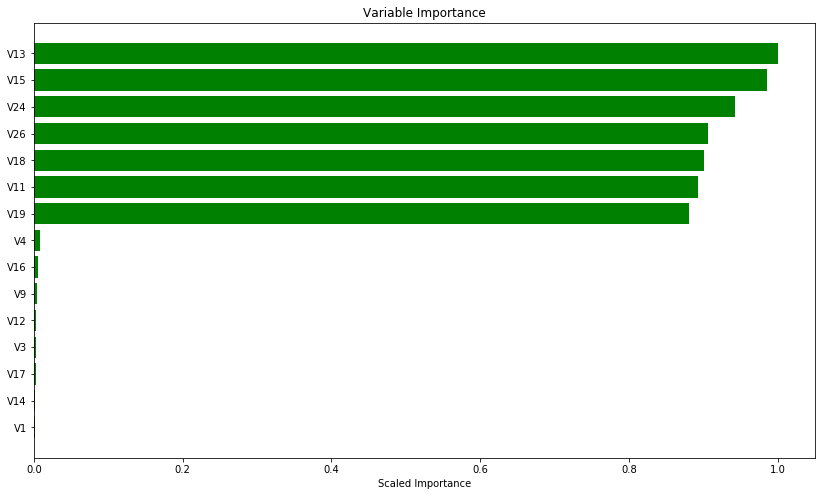

In [10]:
# plotting the variable importance
rcParams['figure.figsize'] = 14, 8
#plt.rcdefaults()
fig, ax = plt.subplots()

variables = anomaly_model._model_json['output']['variable_importances']['variable']
var = variables[0:15]
y_pos = np.arange(len(var))

scaled_importance = anomaly_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:15]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

## Visualize the model lose

Text(0.5, 0, 'epoch')

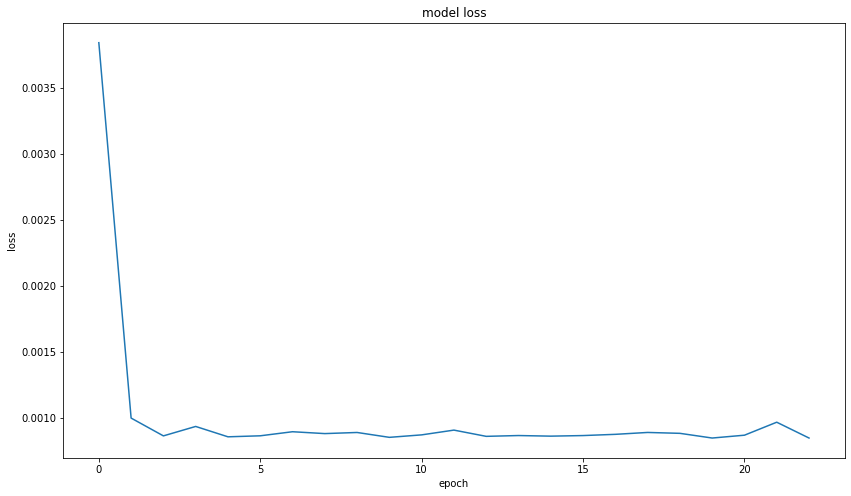

In [20]:
# plotting the loss
scoring_history = anomaly_model.score_history()
%matplotlib inline
rcParams['figure.figsize'] = 14, 8
plt.plot(scoring_history['training_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

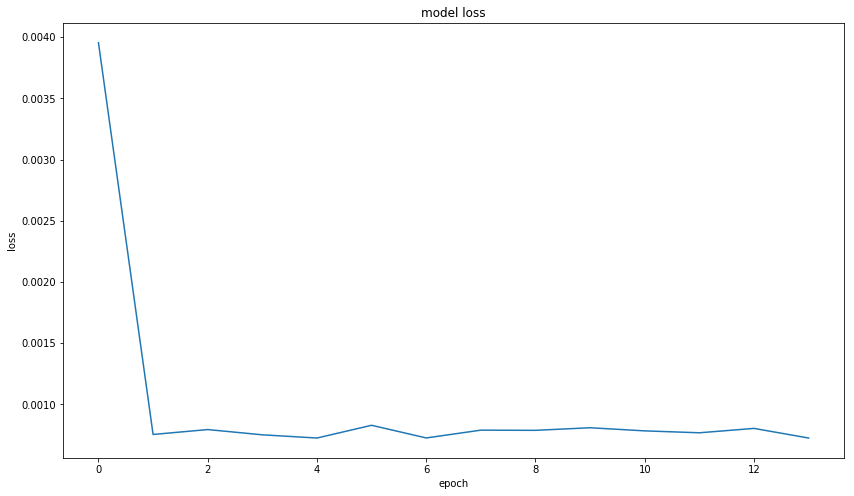

In [11]:
# plotting the loss
scoring_history = anomaly_model.score_history()
%matplotlib inline
rcParams['figure.figsize'] = 14, 8
plt.plot(scoring_history['training_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

## Visualize the scatter plot across the dataset

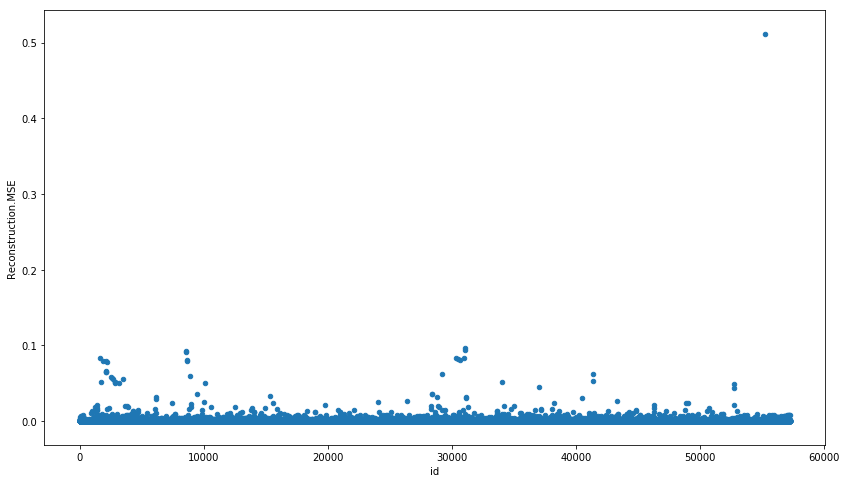

In [12]:
test_rec_error = anomaly_model.anomaly(test_h2o) 
# anomaly is a H2O function which calculates the error for the dataset
# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()
# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index
rcParams['figure.figsize'] = 14, 8
test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")
plt.show()

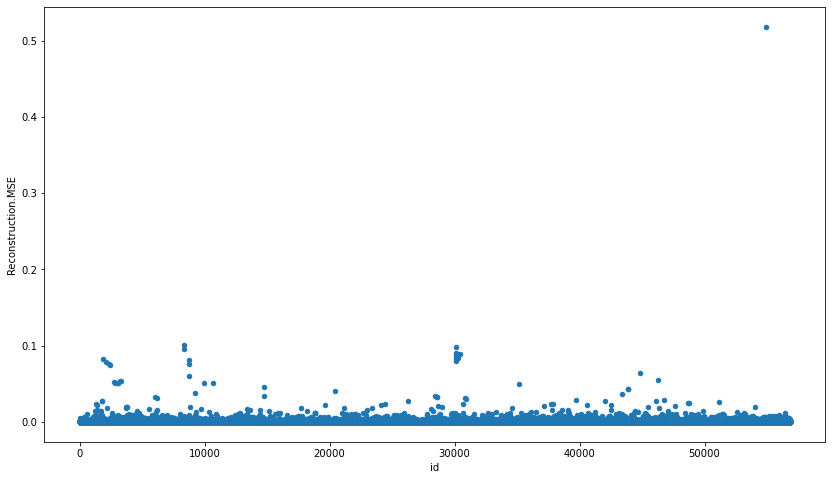

In [21]:
test_rec_error = anomaly_model.anomaly(test_h2o) 
# anomaly is a H2O function which calculates the error for the dataset
# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()
# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index
rcParams['figure.figsize'] = 14, 8
test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")
plt.show()

In [20]:
# predicting the class for the testing dataset
predictions = anomaly_model.predict(test_h2o)
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df})
error_df.groupby('true_class').count()

deeplearning prediction progress: |███████████████████████████████████████| 100%


reconstruction_error
true_class                      
0                          57120
1                            100

In [31]:
predictions

reconstr_V1 reconstr_V2 reconstr_V3 reconstr_V4 reconstr_V5 reconstr_V6 reconstr_V7 reconstr_V8 reconstr_V9 reconstr_V10 reconstr_V11 reconstr_V12 reconstr_V13 reconstr_V14 reconstr_V15 reconstr_V16 reconstr_V17 reconstr_V18 reconstr_V19 reconstr_V20 reconstr_V21 reconstr_V22 reconstr_V23 reconstr_V24 reconstr_V25 reconstr_V26 reconstr_V27 reconstr_V28 reconstr_Amount 
 
 
 0.101295 0.770254 0.449071 -0.145119 -0.053443 0.0416656 0.120387 0.0247328 0.246201 -0.0390272 0.696157 -0.116022 0.72466 0.308402 2.10501 0.129974 -0.0576533 -0.172459 -0.0306523 0.00151013 -0.0238928 -0.1198 -0.0089477 -0.748334 -0.028687 -0.150558 -0.193604 -0.0328379 6.44142 
 -0.116794 0.783053 0.34714 -0.0208785 0.0347185 -0.107319 0.165418 -0.013406 0.246205 -0.0583695 -0.739075 -0.22286 1.24777 0.264067 0.23057 0.00211164 -0.185784 -0.0305504 0.0342977 -0.0194259 -0.0171784 -0.0429388 -0.00404558 0.134422 -0.0661394 0.540747 -0.190083 -0.0396029 17.7499 
 -0.192481 0.728534 0.33067 0.108085 0.16096 -0.00607568 0.205884 -0.00443493 0.217081 -0.10031 -0.667475 -0.216056 -0.403282 0.229772 -0.353666 0.010552 -0.192441 0.15566 -0.0120084 -0.028019 -0.0113519 -0.0474205 -0.0185241 0.929902 -0.0654633 -0.406941 -0.178386 -0.032073 22.5035 
 0.0729236 0.739816 0.473193 -0.0601481 0.0682403 0.0251861 0.213236 -0.0294262 0.240115 0.00608201 0.32341 -0.105138 1.17487 0.342041 0.770706 0.0867451 -0.0103726 -0.883082 0.00807567 -0.00348907 -0.0033204 -0.0489422 -0.000801371 0.412962 -0.0589445 -0.35162 -0.185864 -0.0339897 8.13705 
 0.0262342 0.552204 0.393882 -0.0161514 0.094937 0.165374 0.174596 0.0339897 0.219714 -0.0697061 0.988479 -0.133164 -0.361522 0.329866 -0.555097 0.128065 -0.0491333 0.0905398 -0.0342092 -0.0416294 -0.0228253 -0.11778 -0.0162185 0.0172168 -0.0752779 -0.616199 -0.169655 -0.0237773 23.8089 
 -0.172754 0.850601 0.352516 0.0482158 0.0676168 -0.0490177 0.147978 0.0124234 0.226988 -0.121946 -0.577802 -0.206793 -0.522744 0.193849 1.50439 0.029475 -0.21856 0.45035 -0.0432399 -0.00403867 -0.0182309 -0.0723733 -0.0197799 0.378554 -0.0304489 -0.274674 -0.191536 -0.0334842 14.1238 
 0.092342 0.432738 0.376509 -0.0168898 0.119122 0.205415 0.210566 0.0357451 0.213315 -0.0295877 0.959569 -0.121705 -0.704274 0.369709 -1.49894 0.159944 -0.00878877 -0.407647 -0.0101966 -0.053763 -0.019526 -0.128428 -0.0189515 -0.0196388 -0.0843763 -0.54609 -0.159991 -0.0218748 28.1959 
 0.092342 0.432738 0.376509 -0.0168898 0.119122 0.205415 0.210566 0.0357451 0.213315 -0.0295877 0.959569 -0.121705 -0.704274 0.369709 -1.49894 0.159944 -0.00878877 -0.407647 -0.0101966 -0.053763 -0.019526 -0.128428 -0.0189515 -0.0196388 -0.0843763 -0.54609 -0.159991 -0.0218748 28.1959 
 -0.144941 0.786951 0.385536 0.0542786 0.0548798 -0.189306 0.182412 -0.0332664 0.248324 -0.0864583 -0.431578 -0.185519 -0.118882 0.265912 0.375097 0.0251871 -0.166722 0.136518 0.00806636 -0.00685754 -0.00726056 -0.00592906 0.00664208 0.996543 -0.0726314 1.07581 -0.187958 -0.030789 20.4126 
 -0.031105 0.788263 0.388261 -0.045719 0.0508769 -0.0391512 0.190565 -0.0174259 0.240018 -0.0182804 -0.600897 -0.18173 1.30791 0.283198 0.720237 0.0329895 -0.123522 -0.591028 0.0276569 -0.00926618 -0.0108122 -0.0543499 -0.00874 0.0977767 -0.0502227 -0.0719396 -0.190062 -0.0401919 10.8484

In [22]:
# predicting the class for the testing dataset
predictions = anomaly_model.predict(test_h2o)
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df})
error_df.groupby('true_class').count()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


reconstruction_error
true_class                      
0                          56724
1                            104

## Calculate the threshold score/ cutoff score

In [27]:
score_mean = error_df['reconstruction_error'].mean()
score_std = error_df['reconstruction_error'].std()
score_cutoff = score_mean + 4*score_std
score_cutoff

0.012424082716339331

In [23]:
score_mean = error_df['reconstruction_error'].mean()
score_std = error_df['reconstruction_error'].std()
score_cutoff = score_mean + 4*score_std
score_cutoff

0.012741764269150156

In [22]:
error_df[(error_df['true_class'] == 1) & error_df['reconstruction_error'] > 0.0095].count()

reconstruction_error    100
true_class              100
dtype: int64

In [24]:
error_df[(error_df['true_class'] == 1) & error_df['reconstruction_error'] > 0.0095].count()

reconstruction_error    104
true_class              104
dtype: int64

## Print out the confusion matrix

Adjust and tune the confusion matrix from the threshold.

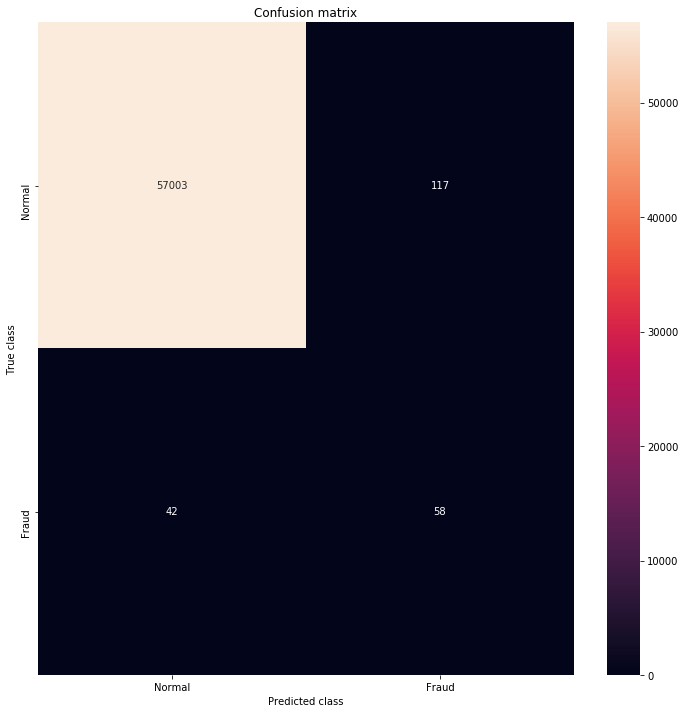

In [30]:
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
threshold = 0.009
LABELS = ['Normal', 'Fraud']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

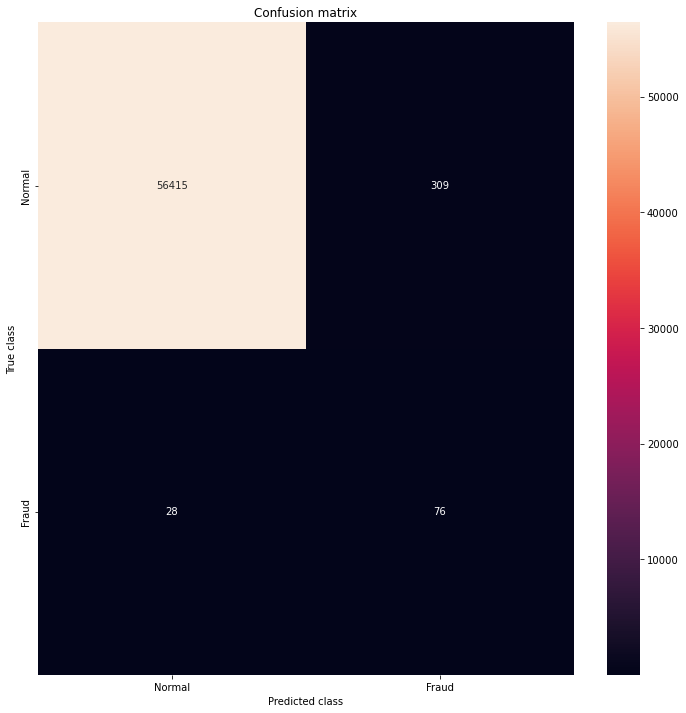

In [30]:
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
threshold = 0.006
LABELS = ['Normal', 'Fraud']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()